# 1D Generative Adversarial Network in Keras

Inspired by [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/)

## Index
1. Selecting a One-Dimensional Function
2. Defining a Discriminator Model
3. Defining a Generator Model
4. Training the Generator Model
5. Evaluating the Performance of the GAN
6. Running the GAN

## GAN Theory
- Generator component creates new, realistic data points (X and Y component)
- Discriminator component classifies if data point is original or generated
- Performance of discriminator is used to update model weights of both generator and discriminator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


## 1. Select a One-Dimensional Function
- f(x) = sin(x)
- Plot sin(x) from -2pi to 2pi

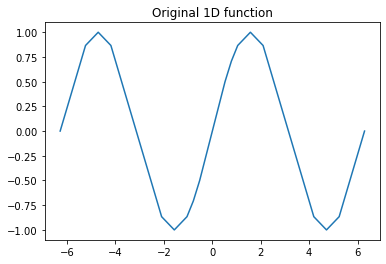

In [2]:
def calculate(x):
    return math.sin(x)

inputs = [0, math.pi/6, math.pi/4, math.pi/3, math.pi/2, 2*math.pi/3, math.pi, 4*math.pi/3, 3*math.pi/2, 5*math.pi/3, 2*math.pi]
inputs.extend([-x for x in inputs[1:]])
inputs.sort()

outputs = [calculate(x) for x in inputs]

plt.plot(inputs, outputs)
plt.title('Original 1D function');

### Generating random samples for f(x)

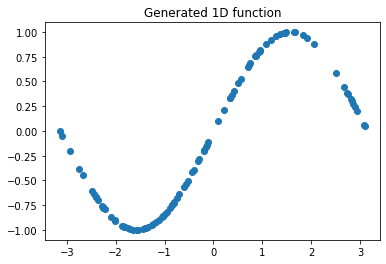

In [3]:
def generate_samples(n=100):
    '''Generates random samples for f(x) from -pi to +pi'''
    X1 = (np.random.rand(n) - 0.5) * 2 * math.pi
    X2 = np.array([calculate(x) for x in X1])
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return np.hstack((X1, X2))

samples = generate_samples()

plt.scatter(samples[:, 0], samples[:, 1])
plt.title('Generated 1D function');

## 2. Define a Discriminator Model
- Binary classifier
- In: sample with two real values
- Out: likelyhood sample is original, not generated

In [4]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='GAN_1D_Keras_discriminator_plot.png', show_shapes=True, show_layer_names=True);

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


#### Discriminator Model Plot
![Discriminator Model](GAN_1D_Keras_discriminator_plot.png 'Discriminator Model')

### Generate real and fake samples
- generate_real_samples creates real samples, where X2 = f(X1)
- generate_fake_samples creates fake samples, where X2 is independently created from X1
- Classification labels are added to each generated value (0 = fake, 1 = real)

In [204]:
def generate_real_samples(n=100):
    '''Generates random samples for f(x) from -pi to +pi'''
    X1 = (np.random.rand(n) - 0.5) * 2 * math.pi
    X2 = np.array([calculate(x) for x in X1])
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return X, y

def generate_fake_samples(n=100):
    '''Generates random samples from -pi to +pi that are not using f(x) for X2'''
    X1 = (np.random.rand(n) - 0.5) * 2 * math.pi    
    X2 = (np.random.rand(n) - 0.5) * 2 * math.pi
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.zeros((n, 1))
    return X, y

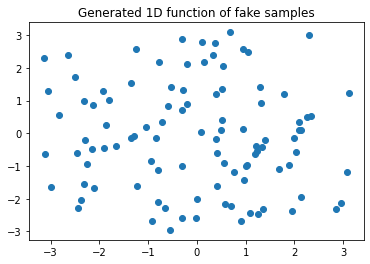

In [205]:
fake_samples, y = generate_fake_samples()
plt.scatter(fake_samples[:, 0], fake_samples[:, 1])
plt.title('Generated 1D function of fake samples');

### Train discriminator
- Update the model with generated data during training
- Generate 50% fake and 50% real samples for each training epoch

In [25]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    '''Manually run epochs for training with generated data'''
    half_batch = int(n_batch/2)
    epoch_hist_real = []
    epoch_hist_fake = []
    for i in range(0, n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        epoch_hist_real.append(model.train_on_batch(X_real, y_real))
        X_fake, y_fake = generate_fake_samples(half_batch)
        epoch_hist_fake.append(model.train_on_batch(X_fake, y_fake))
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print('Epoch {}: acc_real = {}, acc_fake = {}'.format(i, acc_real, acc_fake))
    return epoch_hist_real, epoch_hist_fake

In [26]:
model = define_discriminator()
epoch_hist_real, epoch_hist_fake = train_discriminator(model)

Epoch 0: acc_real = 0.484375, acc_fake = 0.625
Epoch 1: acc_real = 0.40625, acc_fake = 0.625
Epoch 2: acc_real = 0.5625, acc_fake = 0.65625
Epoch 3: acc_real = 0.40625, acc_fake = 0.65625
Epoch 4: acc_real = 0.421875, acc_fake = 0.65625
Epoch 5: acc_real = 0.453125, acc_fake = 0.703125
Epoch 6: acc_real = 0.4375, acc_fake = 0.59375
Epoch 7: acc_real = 0.5, acc_fake = 0.65625
Epoch 8: acc_real = 0.515625, acc_fake = 0.75
Epoch 9: acc_real = 0.515625, acc_fake = 0.78125
Epoch 10: acc_real = 0.59375, acc_fake = 0.75
Epoch 11: acc_real = 0.65625, acc_fake = 0.59375
Epoch 12: acc_real = 0.5625, acc_fake = 0.6875
Epoch 13: acc_real = 0.53125, acc_fake = 0.71875
Epoch 14: acc_real = 0.640625, acc_fake = 0.625
Epoch 15: acc_real = 0.484375, acc_fake = 0.75
Epoch 16: acc_real = 0.484375, acc_fake = 0.703125
Epoch 17: acc_real = 0.4375, acc_fake = 0.609375
Epoch 18: acc_real = 0.59375, acc_fake = 0.765625
Epoch 19: acc_real = 0.484375, acc_fake = 0.6875
Epoch 20: acc_real = 0.46875, acc_fake = 0

Epoch 192: acc_real = 0.84375, acc_fake = 0.828125
Epoch 193: acc_real = 0.828125, acc_fake = 0.84375
Epoch 194: acc_real = 0.796875, acc_fake = 0.828125
Epoch 195: acc_real = 0.875, acc_fake = 0.84375
Epoch 196: acc_real = 0.828125, acc_fake = 0.671875
Epoch 197: acc_real = 0.84375, acc_fake = 0.765625
Epoch 198: acc_real = 0.890625, acc_fake = 0.796875
Epoch 199: acc_real = 0.796875, acc_fake = 0.8125
Epoch 200: acc_real = 0.8125, acc_fake = 0.734375
Epoch 201: acc_real = 0.84375, acc_fake = 0.796875
Epoch 202: acc_real = 0.84375, acc_fake = 0.75
Epoch 203: acc_real = 0.859375, acc_fake = 0.765625
Epoch 204: acc_real = 0.765625, acc_fake = 0.71875
Epoch 205: acc_real = 0.796875, acc_fake = 0.859375
Epoch 206: acc_real = 0.78125, acc_fake = 0.828125
Epoch 207: acc_real = 0.84375, acc_fake = 0.796875
Epoch 208: acc_real = 0.8125, acc_fake = 0.8125
Epoch 209: acc_real = 0.75, acc_fake = 0.84375
Epoch 210: acc_real = 0.828125, acc_fake = 0.875
Epoch 211: acc_real = 0.765625, acc_fake = 0

Epoch 546: acc_real = 1.0, acc_fake = 0.78125
Epoch 547: acc_real = 1.0, acc_fake = 0.796875
Epoch 548: acc_real = 1.0, acc_fake = 0.78125
Epoch 549: acc_real = 1.0, acc_fake = 0.828125
Epoch 550: acc_real = 1.0, acc_fake = 0.890625
Epoch 551: acc_real = 1.0, acc_fake = 0.859375
Epoch 552: acc_real = 1.0, acc_fake = 0.890625
Epoch 553: acc_real = 1.0, acc_fake = 0.796875
Epoch 554: acc_real = 1.0, acc_fake = 0.828125
Epoch 555: acc_real = 1.0, acc_fake = 0.875
Epoch 556: acc_real = 1.0, acc_fake = 0.90625
Epoch 557: acc_real = 1.0, acc_fake = 0.796875
Epoch 558: acc_real = 1.0, acc_fake = 0.84375
Epoch 559: acc_real = 1.0, acc_fake = 0.828125
Epoch 560: acc_real = 1.0, acc_fake = 0.9375
Epoch 561: acc_real = 1.0, acc_fake = 0.828125
Epoch 562: acc_real = 1.0, acc_fake = 0.796875
Epoch 563: acc_real = 1.0, acc_fake = 0.8125
Epoch 564: acc_real = 1.0, acc_fake = 0.8125
Epoch 565: acc_real = 1.0, acc_fake = 0.78125
Epoch 566: acc_real = 1.0, acc_fake = 0.796875
Epoch 567: acc_real = 1.0, 

Epoch 733: acc_real = 1.0, acc_fake = 0.875
Epoch 734: acc_real = 1.0, acc_fake = 0.828125
Epoch 735: acc_real = 1.0, acc_fake = 0.859375
Epoch 736: acc_real = 1.0, acc_fake = 0.84375
Epoch 737: acc_real = 1.0, acc_fake = 0.859375
Epoch 738: acc_real = 1.0, acc_fake = 0.828125
Epoch 739: acc_real = 1.0, acc_fake = 0.828125
Epoch 740: acc_real = 1.0, acc_fake = 0.828125
Epoch 741: acc_real = 1.0, acc_fake = 0.890625
Epoch 742: acc_real = 1.0, acc_fake = 0.859375
Epoch 743: acc_real = 1.0, acc_fake = 0.90625
Epoch 744: acc_real = 1.0, acc_fake = 0.859375
Epoch 745: acc_real = 1.0, acc_fake = 0.84375
Epoch 746: acc_real = 1.0, acc_fake = 0.875
Epoch 747: acc_real = 1.0, acc_fake = 0.859375
Epoch 748: acc_real = 1.0, acc_fake = 0.84375
Epoch 749: acc_real = 1.0, acc_fake = 0.828125
Epoch 750: acc_real = 1.0, acc_fake = 0.796875
Epoch 751: acc_real = 1.0, acc_fake = 0.84375
Epoch 752: acc_real = 1.0, acc_fake = 0.875
Epoch 753: acc_real = 1.0, acc_fake = 0.8125
Epoch 754: acc_real = 1.0, ac

Epoch 919: acc_real = 1.0, acc_fake = 0.921875
Epoch 920: acc_real = 1.0, acc_fake = 0.828125
Epoch 921: acc_real = 1.0, acc_fake = 0.828125
Epoch 922: acc_real = 1.0, acc_fake = 0.875
Epoch 923: acc_real = 1.0, acc_fake = 0.84375
Epoch 924: acc_real = 1.0, acc_fake = 0.859375
Epoch 925: acc_real = 1.0, acc_fake = 0.9375
Epoch 926: acc_real = 1.0, acc_fake = 0.859375
Epoch 927: acc_real = 1.0, acc_fake = 0.890625
Epoch 928: acc_real = 1.0, acc_fake = 0.921875
Epoch 929: acc_real = 1.0, acc_fake = 0.859375
Epoch 930: acc_real = 1.0, acc_fake = 0.921875
Epoch 931: acc_real = 1.0, acc_fake = 0.84375
Epoch 932: acc_real = 1.0, acc_fake = 0.828125
Epoch 933: acc_real = 1.0, acc_fake = 0.875
Epoch 934: acc_real = 1.0, acc_fake = 0.875
Epoch 935: acc_real = 1.0, acc_fake = 0.875
Epoch 936: acc_real = 1.0, acc_fake = 0.828125
Epoch 937: acc_real = 1.0, acc_fake = 0.828125
Epoch 938: acc_real = 0.984375, acc_fake = 0.9375
Epoch 939: acc_real = 0.984375, acc_fake = 0.859375
Epoch 940: acc_real =

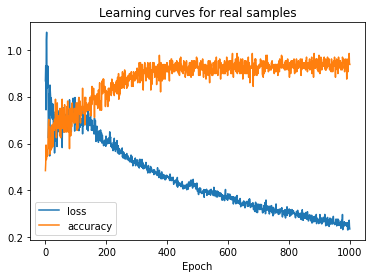

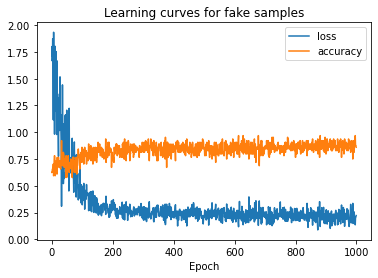

In [27]:
plt.title('Learning curves for real samples')
plt.xlabel('Epoch')
plt.plot(epoch_hist_real)
plt.legend(model.metrics_names)
plt.show()

plt.title('Learning curves for fake samples')
plt.xlabel('Epoch')
plt.plot(epoch_hist_fake)
plt.legend(model.metrics_names)
plt.show();

## 3. Define a Generator Model
- Takes a point from latent (hidden) space to generate a new sample (point with X1 and X2 coordinates)
- Latent space is assigned meaning through the training of the generator model - afterwards points in latent space correspond to points in the output space
- Define latent space with 5 dimensions, each with a Gaussion distribution
- Generation of new inputs by drawing random numbers from a standard Gaussian distribution (mean = 0, std.dev. = 1)
- In: point in latent space, vector with 5 elements from Gaussian distribution
- Out: point in output space, vector with 2 elements, X1 and X2 (or x and f(x))

In [29]:
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

model = define_generator(5)
model.summary()
plot_model(model, to_file='GAN_1D_Keras_generator_plot.png', show_shapes=True, show_layer_names=True);

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 15)                90        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


#### Generator Model Plot
![Generator Model](GAN_1D_Keras_generator_plot.png 'Generator Model')

In [169]:
def generate_latent_points(latent_dim, n):
    '''Generate points in latent space: return n rows of latent_dim points as input for the network.'''
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

def generate_fake_points(generator, latent_dim, n):
    '''Generate fake points based on input from latent space.'''
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    # Disable plotting for training, otherwise outputs 1 plot per epoch!
    #plt.scatter(X[:, 0], X[:, 1])
    #plt.show()
    y = np.zeros((n, 1))
    return X, y

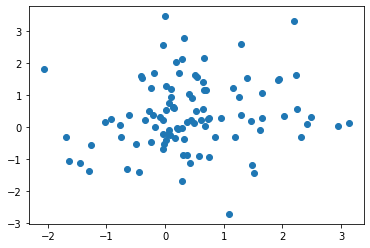

In [77]:
latent_dim = 5
model = define_generator(latent_dim)
generate_fake_points(model, latent_dim, 100);

## 4. Training the Generator Model
- Update weights in the generator model based on the performance of the discriminator model
- Good discriminator performance changes weights of generator more, bad discriminator performance leads to less change --> **adversarial relationship**
- Stack generator and discriminator, so that G receives as input latent space points, generates samples that are fed to D model directly and get classified. Output of this model updates weights of generator.
- In overall model, discriminator model layers must be *non-trainable* to avoid overtraining on fake examples
- Discriminator model must think that generator output samples are real, not fake --> classified as 1
- Leads to large initial error (since actual class is 0, fake) --> large change of weights in generator model

In [50]:
def define_gan(generator, discriminator):
    '''Defines an overall stacked model from the generator and discriminator, with the later tagged as untrainable.'''
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [53]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
gan_model.summary()
plot_model(gan_model, to_file='GAN_1D_Keras_gan_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True);

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 2)                 122       
_________________________________________________________________
sequential_18 (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


#### GAN Model Plot
![GAN Model](GAN_1D_Keras_gan_plot.png 'GAN Model')

In [64]:
def train_gan(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    '''Train generator and discriminator models.'''
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_points(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)    
    return

## 5. Evaluating the Performance of the GAN
- Generally, there are no objective ways to evaluate the performance of a GAN model.
- For a known function, however, objective quality can be calculated i.e. via MSE.
- Real use cases use subjective judgement by comparing generated samples to real samples.

Epoch 0: acc_real = 0.96, acc_fake = 0.84


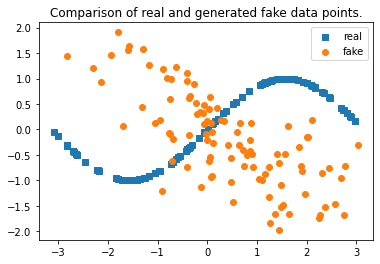

In [189]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    X_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_points(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)
    print('Epoch {}: acc_real = {:.2}, acc_fake = {:.2}'.format(epoch, acc_real, acc_fake))
    plt.title('Comparison of real and generated fake data points.')
    leg_real = plt.scatter(X_real[:, 0], X_real[:, 1], marker='s')
    leg_fake = plt.scatter(X_fake[:, 0], X_fake[:, 1])
    plt.legend((leg_real, leg_fake), ('real', 'fake'))
    plt.show()
    return

summarize_performance(0, generator, discriminator, latent_dim)

In [199]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    '''Train generator and discriminator models.'''
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_points(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if(i+1) % n_eval == 0:
            summarize_performance(i+1, g_model, d_model, latent_dim)
    summarize_performance(i+1, g_model, d_model, latent_dim)
    return

## 6. Running the model
- If model learns correctly, accuracy of classification of the fake generated data points should decrease and finish at around 50% (since 50% of the points are real and 50% are fake)

Epoch 2000: acc_real = 0.57, acc_fake = 0.59


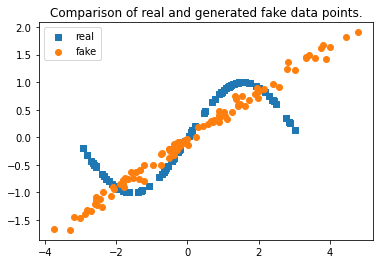

Epoch 4000: acc_real = 0.79, acc_fake = 0.33


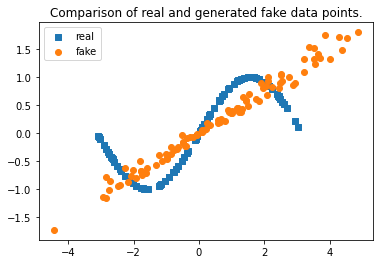

Epoch 6000: acc_real = 0.13, acc_fake = 0.99


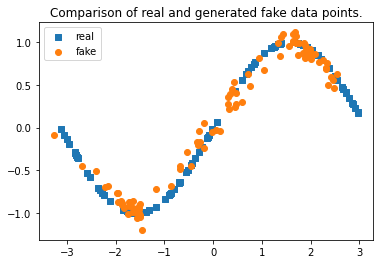

Epoch 8000: acc_real = 0.41, acc_fake = 0.68


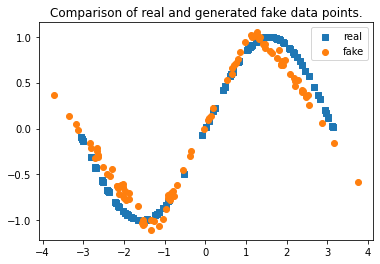

Epoch 10000: acc_real = 0.32, acc_fake = 0.74


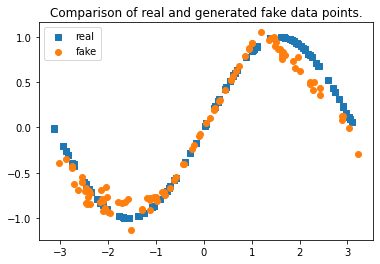

Epoch 12000: acc_real = 0.37, acc_fake = 0.52


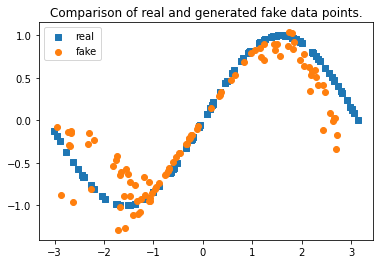

Epoch 12000: acc_real = 0.51, acc_fake = 0.62


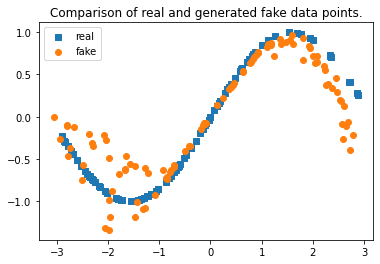

In [206]:
latent_dim = 5
n_epochs = 12000
n_batch = 256
n_eval = 2000

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim, n_epochs, n_batch, n_eval)
#train(generator, discriminator, gan_model, latent_dim)